# Detecting malicious URLs
Some introduction...

## Data exploration and cleaning

### General dataset information

In [1]:
DATASET_PATH = 'datasets/malicious_urls.csv'

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv(DATASET_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [3]:
df.describe()

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [4]:
df.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [5]:
# Remove duplicates
df.drop_duplicates(inplace=True, subset=['url'], keep='last')
count = df.type.value_counts()
count

benign        428074
defacement     95308
phishing       94092
malware        23645
Name: type, dtype: int64

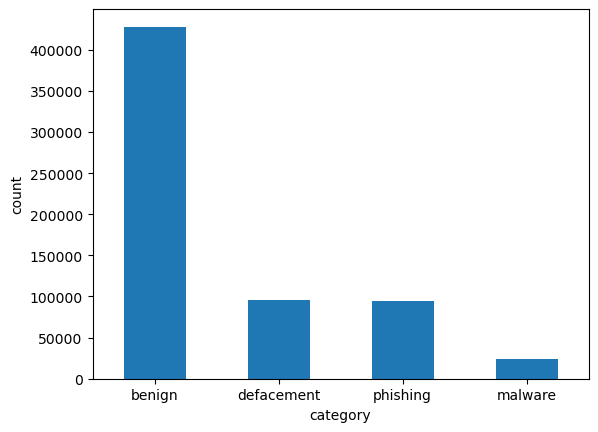

In [6]:
import matplotlib.pyplot as plt
count.plot.bar()
plt.xticks(rotation=0)
plt.xlabel("category")
plt.ylabel("count")
plt.show()

### Character encoding

In [7]:
# Detect character encoding
import chardet

encodings = df['url'].apply(lambda x: chardet.detect(str(x).encode('utf-8')))
df['encoding'] = encodings.apply(lambda x: x['encoding'])
df['enc_confidence'] = encodings.apply(lambda x: x['confidence'])

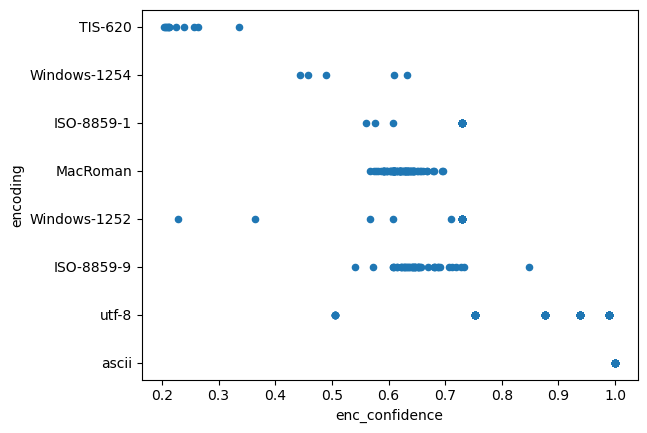

In [8]:
enc_df = pd.DataFrame(df[['encoding', 'enc_confidence']])
enc_df['encoding'] = enc_df['encoding'].apply(lambda x: str(x))
enc_df.drop(enc_df[enc_df.encoding == 'None'].index, inplace=True)
enc_df.plot.scatter(y = 'encoding', x = 'enc_confidence')
 
plt.show()

In [9]:
# By trying some queries we observe that there are some URL strings with broken encoding
df.query(expr='encoding not in ("ascii" , "utf-8")')

,url,type,encoding,enc_confidence
4491,citizendia.org/Agence_métropolitaine_de_transport,benign,ISO-8859-9,0.629187
7564,wn.com/HYMNE_NATIONAL_DU_QUÉBEC,benign,Windows-1252,0.730000
8116,forum.verygames.net/showthread.php?42812-Probl...,benign,MacRoman,0.635195
14053,dictionary.sensagent.com/jehane+benoît/fr-fr/,benign,ISO-8859-9,0.682751
14853,dictionary.sensagent.com/université+de+sherbro...,benign,MacRoman,0.621045
...,...,...,...,...
573492,ÆÖY'uEdS*Z£ñ>7ñV\pìnY÷¡ß¬á'×?...,phishing,TIS-620,0.210592
573495,ùAyéTôDpFc~h@^¶\øâèû¥ÊÞG·ê(Tøì\0«Y=D ...,phishing,None,0.000000
573499,=Rãmôj³{è!ÀM¶6<N>w ¼Cf£]4ÍnÝÌ,phishing,None,0.000000
573507,«Düéºþ +ZIdN Ö-lh9L©hDKÄúhßÆ%YqÃ±¹d,phishing,None,0.000000


In [10]:
# Attempt to fix some broken encoding
from ftfy import fix_encoding

df_fixed = pd.DataFrame()
df_fixed['url'] = df['url']
df_fixed['url_fixed'] = df_fixed['url'].apply(fix_encoding)
df_fixed.query(expr='url != url_fixed')

,url,url_fixed
44274,zoominfo.com/people/de%20GrandprÃ©_Jean_344774...,zoominfo.com/people/de%20Grandpré_Jean_3447745...
61961,http://www.scsrxx.com/js/?https://secure.runes...,http://www.scsrxx.com/js/?https://secure.runes...
126643,zoominfo.com/people/Sagan_FranÃƒÆ’Ã‚Â§oise_147...,zoominfo.com/people/Sagan_Françoise_1473040483...
300255,castroller.com/podcasts/CanaluPodcasts3/128646...,castroller.com/podcasts/CanaluPodcasts3/128646...
360359,zoominfo.com/people/SÃ©vigny_Danielle_15449882...,zoominfo.com/people/Sévigny_Danielle_154498825...
...,...,...
573506,r $ÐcYõ,r $Ðc˜‚Yõ
573507,«Düéºþ +ZIdN Ö-lh9L©hDKÄúhßÆ%YqÃ±¹d,«Dü‘éºþ +ZIdN Ö-lh9L©hŽDKÄúhßÆ%Yqñ¹d
573508,Þ~³\(ÿÇ½Jú$Xm £ÜëÃ5{¾kÜãCê_QÊ©B ÇÈc2...,އ~³„Ÿ\(ÿǽJú$Xm £ÜëÃ5{¾kÜãCê_QÊ©B…ǆÈc2#S...
573509,"ëËl×uÏB'JI¨GÙn""Ç( 0","ëËl×uÏB'JI¨GÙn""Ç(…0"


In [11]:
# Commit changes and check for strings that are still broken
df['url'] = df_fixed['url_fixed']
df.query('enc_confidence < 0.5')    # Includes all unidentified encodings

,url,type,encoding,enc_confidence
573417,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,phishing,None,0.000000
573418,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,phishing,None,0.000000
573422,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,phishing,TIS-620,0.264226
573424,esxcc.com/js/index.htm?us.battle.net/login/en/...,phishing,Windows-1254,0.490066
573425,esxcc.com/js/index.htm?us.battle.net/login/en/...,phishing,Windows-1252,0.228806
573427,>Iq9E) l¬0™ZÝìÃw!'Ôp£ãW§&£Ñ p&$ImÞôöÝYÖ,phishing,TIS-620,0.257015
573429,esxcc.com/js/index.htm?us.battle.net/login/en/...,phishing,TIS-620,0.203882
573430,"˜ ꭛~l‡+×û¢ïÄÁŒR""+íI",phishing,None,0.000000
573431,ŠRybjUxÙãl5»7ÆE%ÝÔk+h |U+ýk©ìɔ½“Æq]âF·žõÁ...,phishing,None,0.000000
573432,§¬I0f9ÎPðÏ}åç`.7õú X '˜}—؁4~æʸa(_à,phishing,TIS-620,0.335509


In [12]:
# It seems there is an interval of rows where these invalid urls are concentrated
df.loc[573418:573510]

,url,type,encoding,enc_confidence
573418,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,phishing,None,0.000000
573419,'www.institutocgr.coo/web/media/syqvem/dk-óij...,phishing,Windows-1252,0.730000
573420,Yìê‡ koãջΧDéÎl½ñ¡ââqtò¸/à; Í,phishing,utf-8,0.990000
573421,虠kvüDâQÎé4¼ÒŽ©,benign,utf-8,0.990000
573422,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,phishing,TIS-620,0.264226
...,...,...,...,...
573506,r $Ðc˜‚Yõ,phishing,utf-8,0.990000
573507,«Dü‘éºþ +ZIdN Ö-lh9L©hŽDKÄúhßÆ%Yqñ¹d,phishing,None,0.000000
573508,އ~³„Ÿ\(ÿǽJú$Xm £ÜëÃ5{¾kÜãCê_QÊ©B…ǆÈc2#S...,phishing,None,0.000000
573509,"ëËl×uÏB'JI¨GÙn""Ç(…0",phishing,utf-8,0.990000


In [13]:
# Remove urls we can't fix
df.drop(df.loc[573418:573510].index, inplace=True)

In [14]:
# Remove enc_confidence as it will not be needed for training
df.drop('enc_confidence', axis=1, inplace=True)

### Prepare URLs for parsing

In [15]:
import re

# Add // before every URL so that urllib.parse can detect the netloc part correctly (https://docs.python.org/3/library/urllib.parse.html#urllib.parse.urlparse)
df['url'] = df['url'].apply(lambda x: '//' + str(x) if not re.match(pattern="^.{0,5}:\/\/", string=str(x)) else str(x))
df.head(10)

,url,type,encoding
0,//br-icloud.com.br,phishing,ascii
1,//mp3raid.com/music/krizz_kaliko.html,benign,ascii
2,//bopsecrets.org/rexroth/cr/1.htm,benign,ascii
3,http://www.garage-pirenne.be/index.php?option=...,defacement,ascii
4,http://adventure-nicaragua.net/index.php?optio...,defacement,ascii
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,ascii
6,//espn.go.com/nba/player/_/id/3457/brandon-rush,benign,ascii
7,//yourbittorrent.com/?q=anthony-hamilton-soulife,benign,ascii
8,http://www.pashminaonline.com/pure-pashminas,defacement,ascii
9,//allmusic.com/album/crazy-from-the-heat-r16990,benign,ascii


In [16]:
from urllib.parse import urlparse

# Check if we have any exceptions while parsing
success = True
for url in df['url']:
    try:
        urlparse(url)
    except ValueError as e:
        success = False
        print(e)
if success :
    print('no errors.')

no errors.


In [17]:
# Check again for duplicates since we changed some urls
df.drop_duplicates(inplace=True, subset=['url'], keep='last')

## Feature extraction

In [18]:
from math import log

def shannon_entropy(s):
    freqs = [s.count(i) / len(s) for i in set(s)]
    return -sum([p * log(p, 2.0) for p in freqs])

df['entropy'] = df['url'].apply(shannon_entropy)

df['length'] = df['url'].apply(lambda x: len(str(x)))

urls = df['url'].apply(urlparse)

df['hostname'] = urls.apply(lambda x: x.hostname)
df['port'] = urls.apply(lambda x: x.port).astype('Int64')
df['protocol'] = urls.apply(lambda x: x.scheme)
df['path'] = urls.apply(lambda x: x.path)
df['query'] = urls.apply(lambda x: x.query)
df['fragment'] = urls.apply(lambda x: x.fragment)

df.head(10)

,url,type,encoding,entropy,length,hostname,port,protocol,path,query,fragment
0,//br-icloud.com.br,phishing,ascii,3.503258,18,br-icloud.com.br,<NA>,,,,
1,//mp3raid.com/music/krizz_kaliko.html,benign,ascii,4.053916,37,mp3raid.com,<NA>,,/music/krizz_kaliko.html,,
2,//bopsecrets.org/rexroth/cr/1.htm,benign,ascii,3.666093,33,bopsecrets.org,<NA>,,/rexroth/cr/1.htm,,
3,http://www.garage-pirenne.be/index.php?option=...,defacement,ascii,4.660343,88,www.garage-pirenne.be,<NA>,http,/index.php,option=com_content&view=article&id=70&vsig70_0=15,
4,http://adventure-nicaragua.net/index.php?optio...,defacement,ascii,5.491293,235,adventure-nicaragua.net,<NA>,http,/index.php,option=com_mailto&tmpl=component&link=aHR0cDov...,
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,ascii,4.240544,118,buzzfil.net,<NA>,http,/m/show-art/ils-etaient-loin-de-s-imaginer-que...,,
6,//espn.go.com/nba/player/_/id/3457/brandon-rush,benign,ascii,4.314915,47,espn.go.com,<NA>,,/nba/player/_/id/3457/brandon-rush,,
7,//yourbittorrent.com/?q=anthony-hamilton-soulife,benign,ascii,4.222794,48,yourbittorrent.com,<NA>,,/,q=anthony-hamilton-soulife,
8,http://www.pashminaonline.com/pure-pashminas,defacement,ascii,4.083765,44,www.pashminaonline.com,<NA>,http,/pure-pashminas,,
9,//allmusic.com/album/crazy-from-the-heat-r16990,benign,ascii,4.314915,47,allmusic.com,<NA>,,/album/crazy-from-the-heat-r16990,,


In [19]:
df['port'].unique()

<IntegerArray>
[ <NA>,  8001,  7674,  8881,  8890,  9010,   444,  7890,    84,  8080,
 ...
    83, 10080,    88, 49160,  8002,  8008,  8090,  8000,    70,  8192]
Length: 3875, dtype: Int64

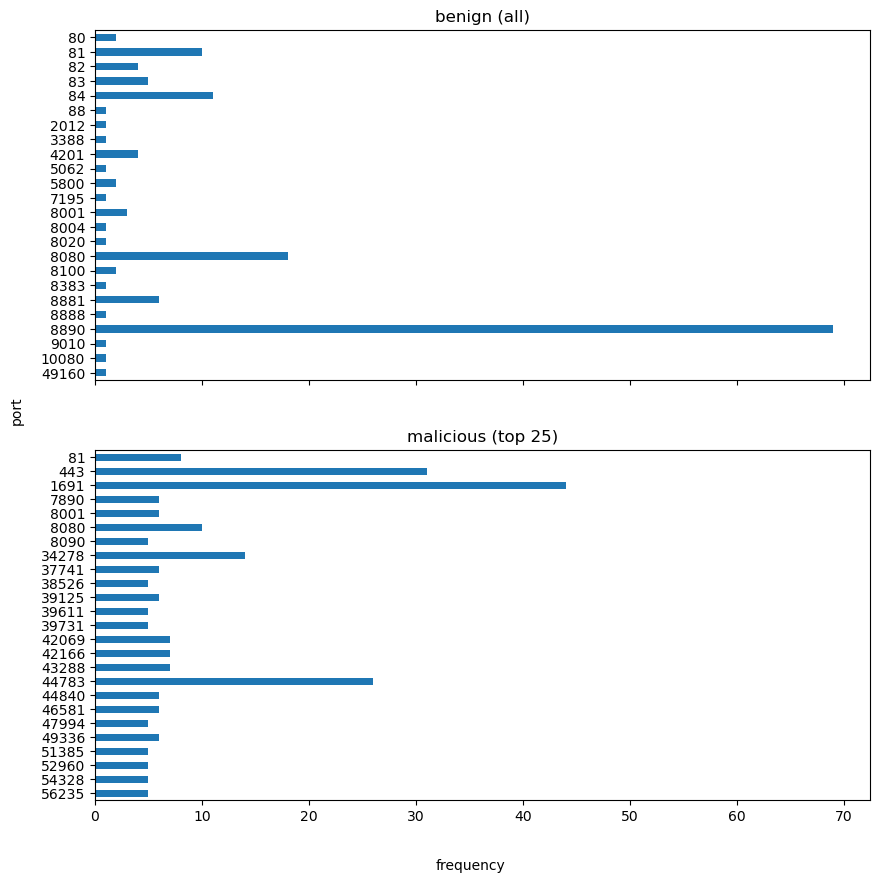

In [20]:
benign = df.query(expr='type == "benign"')['port'].value_counts()
malicious= df.query(expr='type != "benign"')['port'].value_counts()
malicious.drop(malicious.iloc[25:].index, inplace=True)

fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax1 = axs[0]
ax2 = axs[1]
benign.sort_index(ascending=False).plot.barh(ax=ax1)
ax1.set_title('benign (all)')
malicious.sort_index(ascending=False).plot.barh(ax=ax2)
ax2.set_title('malicious (top 25)')
fig.text(0.5, 0.04, 'frequency', ha='center')
fig.text(0.04, 0.5, 'port', va='center', rotation='vertical')

plt.show()

In [21]:
from urllib.parse import parse_qs

df['query_length'] = df['query'].apply(lambda x: len(str(x)))

df['query_args'] = df['query'].apply(lambda x: len(parse_qs(x)))

In [22]:
from pathlib import Path

df['path_length'] = df['path'].apply(lambda x: len(str(x)))

df['path_depth'] = df['path'].apply(lambda x: len(Path(str(x)).parents))

In [23]:
import ipaddress
import tldextract as tldx

def is_ip(url):
    try:
        ip = ipaddress.ip_address(url)
    except:
        return False
    return str(ip) == url

def count_subdomains(hostname, has_ip):
    if has_ip:
        return 0
    else:
        ext = tldx.extract(hostname)
        return len(ext.subdomain.split('.'))

def extract_tld(hostname, has_ip):
    if has_ip:
        return ''
    else:
        ext = tldx.extract(hostname)
        return ext.suffix
    

df['hostname_length'] = df['hostname'].apply(lambda x: len(str(x)))
df['has_ip'] = df['hostname'].apply(lambda x: 1 if is_ip(str(x)) else 0)
df['num_subdomains'] = df.apply(lambda row: count_subdomains(row['hostname'], row['has_ip']), axis=1)
df['tld'] = df.apply(lambda row: extract_tld(row['hostname'], row['has_ip']), axis=1)

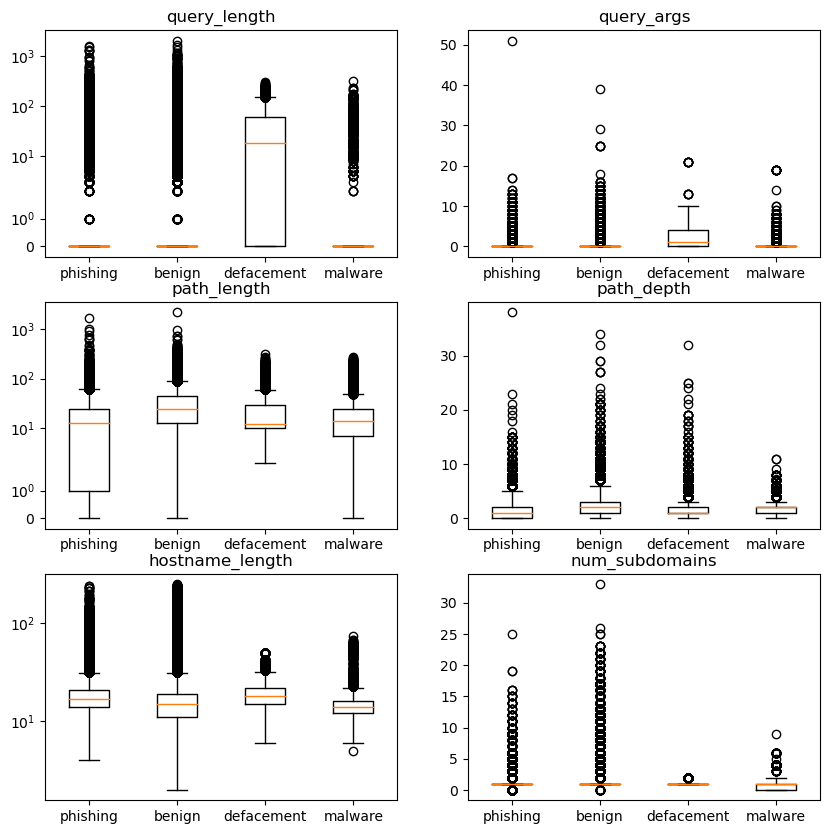

In [24]:
features = ['query_length', 'query_args', 'path_length', 'path_depth', 'hostname_length', 'num_subdomains']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.boxplot([df[df['type'] == t][feature] for t in df['type'].unique()])
    ax.set_title(feature)
    ax.set_xticklabels(df['type'].unique())
    if(feature in ['query_length', 'path_length', 'hostname_length']):
        ax.set_yscale('symlog')

plt.show()

In [25]:
df['has_urlencoded_char'] = df['url'].apply(lambda x: 1 if '%' in str(x) else 0)
df['is_abnormal_url'] = df['protocol'].apply(lambda x: 1 if str(x) == '' else 0)
df['has_fragment'] = df['fragment'].apply(lambda x: 1 if str(x) != '' else 0)

In [26]:
# Match URL shorteners
SHORTENERS = 'datasets/shorteners.txt'

with open(SHORTENERS, 'r') as f:
    shorteners = [line.strip() for line in f.readlines()]

df['is_shortener'] = df['hostname'].apply(lambda x: 1 if x in shorteners else 0)

df.query('is_shortener == 1')['url'].count()

1112

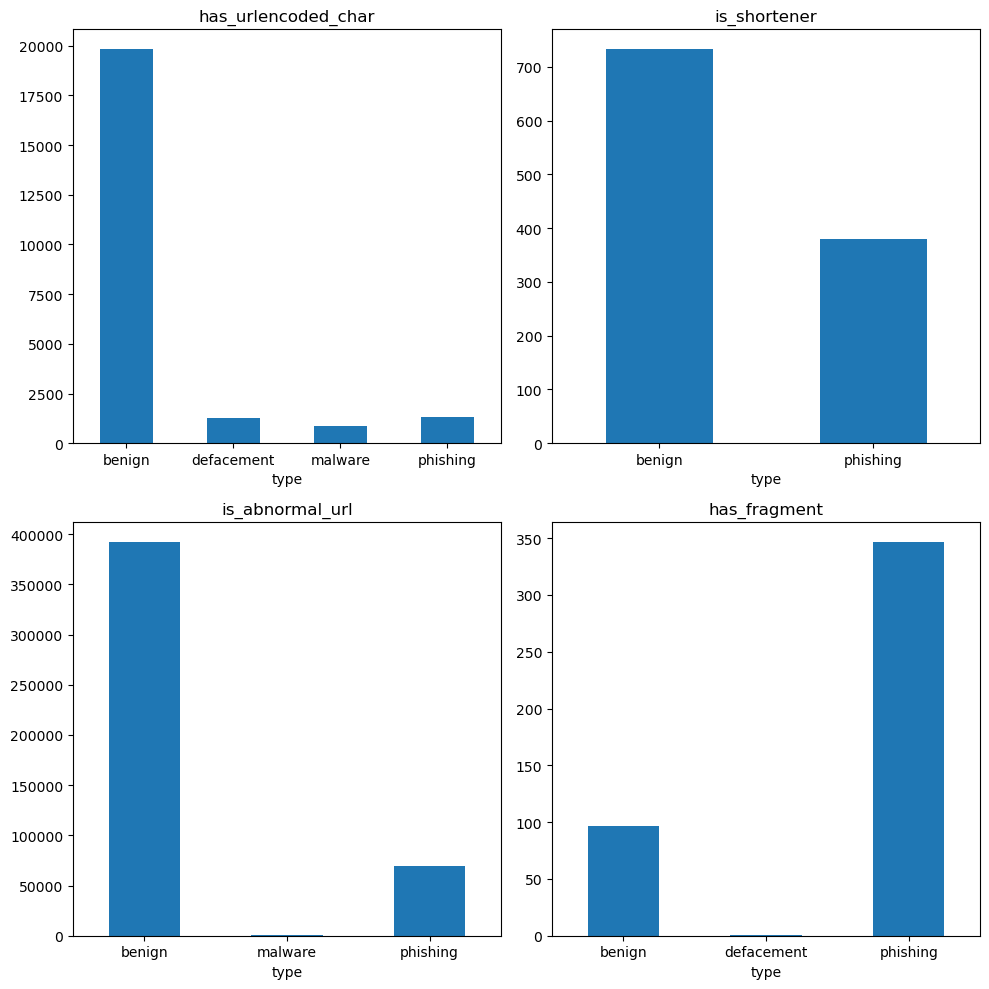

In [27]:
features = ['has_urlencoded_char', 'is_shortener', 'is_abnormal_url', 'has_fragment']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    bars = df[df[feature] == 1].groupby('type')[feature].count().plot.bar(ax=ax, rot=0)
    ax.set_title(feature)

plt.tight_layout()
plt.show()

<Axes: >

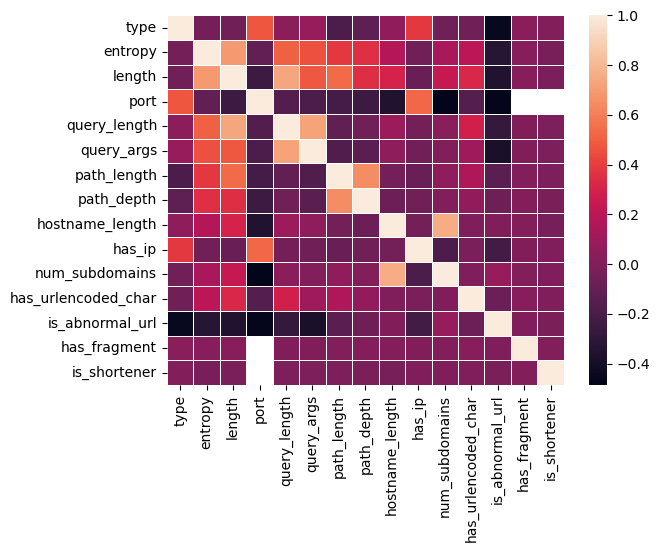

In [28]:
import seaborn as sns

plt.figure()
temp_df = df.copy()
temp_df['type'] = temp_df['type'].apply(lambda x: 1 if x == 'defacement' else 2 if x == 'phishing' else 3 if x == 'malware' else 0)
sns.heatmap(temp_df.corr(numeric_only=True), linewidths=.5)

## Training set

In [29]:
print(df['type'].value_counts())
train_Y = df['type'].apply(lambda x: 'malicious' if x != 'benign' else x)
train_x_raw = df.drop(columns=['url', 'type', 'hostname', 'path', 'query', 'fragment', 'tld'])

print(train_Y.value_counts())
train_x_raw.describe(include='all')

benign        428072
defacement     95308
phishing       93989
malware        23645
Name: type, dtype: int64
benign       428072
malicious    212942
Name: type, dtype: int64


,encoding,entropy,length,port,protocol,query_length,query_args,path_length,path_depth,hostname_length,has_ip,num_subdomains,has_urlencoded_char,is_abnormal_url,has_fragment,is_shortener
count,641013,641014.000000,641014.000000,5141.0,641014,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000
unique,7,NaN,NaN,<NA>,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ascii,NaN,NaN,<NA>,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,640203,NaN,NaN,<NA>,463070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,4.207812,61.200038,42396.71951,NaN,11.572874,0.544636,28.513716,2.074264,17.405997,0.018917,1.086831,0.036294,0.722402,0.000694,0.001735
std,NaN,0.414325,44.552114,14914.113409,NaN,34.030121,1.361899,27.937355,1.593860,11.351191,0.136232,0.818694,0.187021,0.447814,0.026339,0.041614
min,NaN,1.779908,7.000000,70.0,NaN,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,3.945465,33.000000,36851.0,NaN,0.000000,0.000000,10.000000,1.000000,12.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,4.213731,48.000000,45211.0,NaN,0.000000,0.000000,21.000000,2.000000,16.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,NaN,4.482926,78.000000,53106.0,NaN,0.000000,0.000000,39.000000,3.000000,20.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000


In [30]:
col_names = np.array(train_x_raw.columns)

nominal_idx = [np.where(col_names == 'encoding')[0][0], np.where(col_names == 'protocol')[0][0]]
binary_idx = [np.where(col_names == 'has_ip')[0][0], np.where(col_names == 'has_urlencoded_char')[0][0], np.where(col_names == 'is_shortener')[0][0], 
            np.where(col_names == 'is_abnormal_url')[0][0], np.where(col_names == 'has_fragment')[0][0]]
numeric_idx = list(set(range(len(col_names))).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

print(numeric_cols)
print(binary_cols)
print(nominal_cols)

train_x_raw[binary_cols].describe().transpose()

['entropy', 'length', 'port', 'query_length', 'query_args', 'path_length', 'path_depth', 'hostname_length', 'num_subdomains']
['has_ip', 'has_urlencoded_char', 'is_shortener', 'is_abnormal_url', 'has_fragment']
['encoding', 'protocol']


,count,mean,std,min,25%,50%,75%,max
has_ip,641014.0,0.018917,0.136232,0.0,0.0,0.0,0.0,1.0
has_urlencoded_char,641014.0,0.036294,0.187021,0.0,0.0,0.0,0.0,1.0
is_shortener,641014.0,0.001735,0.041614,0.0,0.0,0.0,0.0,1.0
is_abnormal_url,641014.0,0.722402,0.447814,0.0,0.0,1.0,1.0,1.0
has_fragment,641014.0,0.000694,0.026339,0.0,0.0,0.0,0.0,1.0


In [31]:
train_x_raw['port'] = train_x_raw['port'].apply(lambda x: x if pd.notna(x) else 0)

In [32]:
train_x = pd.get_dummies(train_x_raw, columns=nominal_cols, drop_first=True)
dummy_variables = list(set(train_x)-set(train_x_raw))
train_x.describe()

,entropy,length,port,query_length,query_args,path_length,path_depth,hostname_length,has_ip,num_subdomains,...,is_shortener,encoding_ISO-8859-9,encoding_MacRoman,encoding_Windows-1252,encoding_Windows-1254,encoding_ascii,encoding_utf-8,protocol_ftp,protocol_http,protocol_https
count,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,...,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000
mean,4.207812,61.200038,340.026169,11.572874,0.544636,28.513716,2.074264,17.405997,0.018917,1.086831,...,0.001735,0.000070,0.000126,0.000064,0.000003,0.998735,0.000939,0.000003,0.253200,0.024394
std,0.414325,44.552114,4010.482861,34.030121,1.361899,27.937355,1.593860,11.351191,0.136232,0.818694,...,0.041614,0.008378,0.011240,0.007997,0.001766,0.035547,0.030631,0.001766,0.434845,0.154270
min,1.779908,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.945465,33.000000,0.000000,0.000000,0.000000,10.000000,1.000000,12.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,4.213731,48.000000,0.000000,0.000000,0.000000,21.000000,2.000000,16.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,4.482926,78.000000,0.000000,0.000000,0.000000,39.000000,3.000000,20.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,7.511675,2177.000000,65509.000000,2005.000000,51.000000,2156.000000,38.000000,248.000000,1.000000,33.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Training and cross-validation

In [33]:
from sklearn.model_selection import StratifiedKFold

K_FOLDS = 10
skf = StratifiedKFold(K_FOLDS, shuffle=True, random_state=42)

In [34]:
names = ['accuracy', 'precision', 'recall', 'f1_score']

def print_metrics(results):
    for name in names:
        print(f'{name:15}', np.round(results["test_"+name].mean(),3), [np.round(elem,3) for elem in results["test_"+name]])

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, accuracy_score, f1_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler

In [36]:
SGD_pipe = Pipeline([('norm', StandardScaler()), ('rbf', RBFSampler()), ('clf', SGDClassifier())])
MLP_pipe = Pipeline([('norm', StandardScaler()), ('clf', MLPClassifier())])
NB_clf = GaussianNB()
DT_clf = DecisionTreeClassifier()
RF_clf = RandomForestClassifier()

pipes = [RF_clf, DT_clf, NB_clf, MLP_pipe, SGD_pipe]
labels = ['RF', 'DT', 'NB', 'MLP', 'SGD']
cross = dict()

for pipe, l in zip(pipes, labels):
    cross[l] = cross_validate(pipe, train_x, train_Y, scoring={
                                                    'precision': make_scorer(precision_score, pos_label='malicious'),
                                                    'recall': make_scorer(recall_score, pos_label='malicious'),
                                                    'f1_score': make_scorer(f1_score, pos_label='malicious'),
                                                    'accuracy': make_scorer(accuracy_score)},
                                return_estimator=True,
                                cv = skf,
                                n_jobs=-1)

In [37]:
for l in labels:
    print(f'{l}')
    print_metrics(cross[l])
    print()

RF
accuracy        0.926 [0.925, 0.929, 0.926, 0.928, 0.924, 0.925, 0.926, 0.926, 0.927, 0.927]
precision       0.91 [0.91, 0.912, 0.909, 0.911, 0.906, 0.906, 0.912, 0.908, 0.911, 0.913]
recall          0.863 [0.858, 0.869, 0.865, 0.867, 0.86, 0.863, 0.858, 0.865, 0.865, 0.863]
f1_score        0.886 [0.883, 0.89, 0.886, 0.889, 0.882, 0.884, 0.885, 0.886, 0.888, 0.887]

DT
accuracy        0.917 [0.915, 0.919, 0.917, 0.918, 0.915, 0.918, 0.916, 0.918, 0.918, 0.919]
precision       0.887 [0.887, 0.888, 0.885, 0.888, 0.884, 0.89, 0.888, 0.887, 0.887, 0.891]
recall          0.86 [0.853, 0.865, 0.861, 0.863, 0.856, 0.859, 0.856, 0.862, 0.862, 0.861]
f1_score        0.873 [0.869, 0.876, 0.873, 0.875, 0.87, 0.874, 0.872, 0.874, 0.874, 0.876]

NB
accuracy        0.847 [0.844, 0.848, 0.847, 0.848, 0.848, 0.848, 0.847, 0.846, 0.848, 0.846]
precision       0.886 [0.878, 0.889, 0.877, 0.894, 0.889, 0.894, 0.888, 0.881, 0.888, 0.885]
recall          0.619 [0.615, 0.62, 0.627, 0.617, 0.619, 0.614, 0.

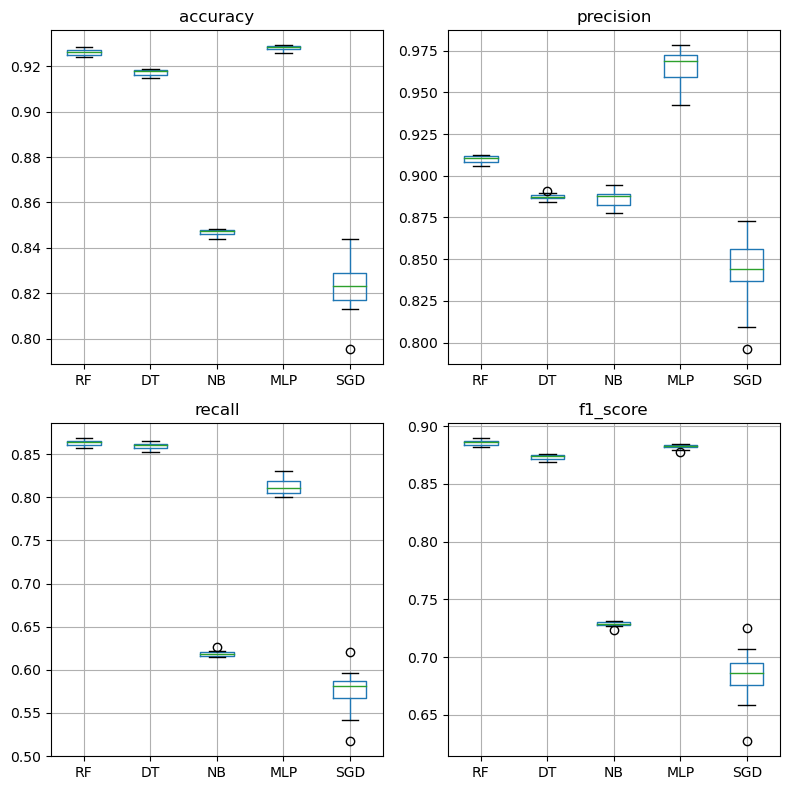

In [38]:
default_metrics = dict()

for n in names:
    default_metrics[n] = pd.DataFrame({l:cross[l]['test_' + n] for l in labels})

def plot_metrics(metrics: dict):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    for i, metric in enumerate(metrics.values()):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        bars = metric.boxplot(ax=ax, rot=0)
        ax.set_title(names[i])

    plt.tight_layout()
    plt.show()

plot_metrics(default_metrics)

In [70]:
from scipy.stats import wilcoxon

P_VALUE_MAX = 0.05

def perform_wilcoxon_tests(classifier_names: list, metrics: dict, metric_names: list) -> dict:
    wilcoxon_tests = dict()
    for m, metric in enumerate(metrics.values()):
        wilcoxon_tests[metric_names[m]] = pd.DataFrame(index=classifier_names, columns=classifier_names)
        for i, col1 in enumerate(classifier_names):
            for j, col2 in enumerate(classifier_names):
                if i != j:
                    wilcoxon_tests[metric_names[m]].loc[col1, col2] = wilcoxon(metric[col1], metric[col2])
    return wilcoxon_tests

def_wilcoxon_test = perform_wilcoxon_tests(labels, default_metrics, names)

In [40]:
from IPython.display import display

def wilcoxon_print(wilcoxon_test):
    for name, df in zip(names, wilcoxon_test.values()):
        print(name)
        display(df)
        print()

In [41]:
wilcoxon_print(def_wilcoxon_test)

accuracy


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(1.0, 0.00390625)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(1.0, 0.00390625)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



precision


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(22.0, 0.625)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(22.0, 0.625)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



recall


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(1.0, 0.00390625)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(1.0, 0.00390625)","(0.0, 0.001953125)",NaN



f1_score


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN


## Training and cross-validation with random undersampling

In [42]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

under_sampler = RandomUnderSampler(random_state=42)

us_SGD_pipe = Pipeline([('sample', under_sampler), ('norm', StandardScaler()), ('rbf', RBFSampler()), ('clf', SGDClassifier())])
us_MLP_pipe = Pipeline([('sample', under_sampler), ('norm', StandardScaler()), ('clf', MLPClassifier())])
us_NB_pipe = Pipeline([('sample', under_sampler), ('clf', GaussianNB())])
us_DT_pipe = Pipeline([('sample', under_sampler), ('clf', DecisionTreeClassifier())])
us_RF_pipe = Pipeline([('sample', under_sampler), ('clf', RandomForestClassifier())])

us_pipes = [us_RF_pipe, us_DT_pipe, us_NB_pipe, us_MLP_pipe, us_SGD_pipe]
us_cross = dict()

for pipe, l in zip(us_pipes, labels):
    us_cross[l] = cross_validate(pipe, train_x, train_Y, scoring={
                                                    'precision': make_scorer(precision_score, pos_label='malicious'),
                                                    'recall': make_scorer(recall_score, pos_label='malicious'),
                                                    'f1_score': make_scorer(f1_score, pos_label='malicious'),
                                                    'accuracy': make_scorer(accuracy_score)},
                                return_estimator=True,
                                cv = skf,
                                n_jobs=-1)

In [43]:
for l in labels:
    print(f'{l}')
    print_metrics(us_cross[l])
    print()

RF
accuracy        0.911 [0.909, 0.912, 0.912, 0.913, 0.91, 0.911, 0.911, 0.911, 0.912, 0.913]
precision       0.848 [0.845, 0.848, 0.846, 0.849, 0.846, 0.848, 0.849, 0.848, 0.85, 0.851]
recall          0.893 [0.888, 0.897, 0.897, 0.898, 0.89, 0.892, 0.891, 0.893, 0.894, 0.894]
f1_score        0.87 [0.866, 0.872, 0.871, 0.873, 0.868, 0.87, 0.869, 0.87, 0.871, 0.872]

DT
accuracy        0.897 [0.894, 0.899, 0.896, 0.898, 0.896, 0.897, 0.896, 0.896, 0.897, 0.898]
precision       0.817 [0.814, 0.819, 0.814, 0.818, 0.817, 0.817, 0.817, 0.815, 0.818, 0.819]
recall          0.888 [0.884, 0.891, 0.889, 0.892, 0.887, 0.887, 0.885, 0.89, 0.888, 0.89]
f1_score        0.851 [0.847, 0.854, 0.85, 0.853, 0.85, 0.851, 0.85, 0.851, 0.852, 0.853]

NB
accuracy        0.845 [0.841, 0.847, 0.843, 0.846, 0.845, 0.846, 0.845, 0.843, 0.847, 0.845]
precision       0.871 [0.861, 0.88, 0.857, 0.875, 0.868, 0.88, 0.873, 0.862, 0.88, 0.877]
recall          0.626 [0.623, 0.625, 0.635, 0.625, 0.629, 0.622, 0.624, 0

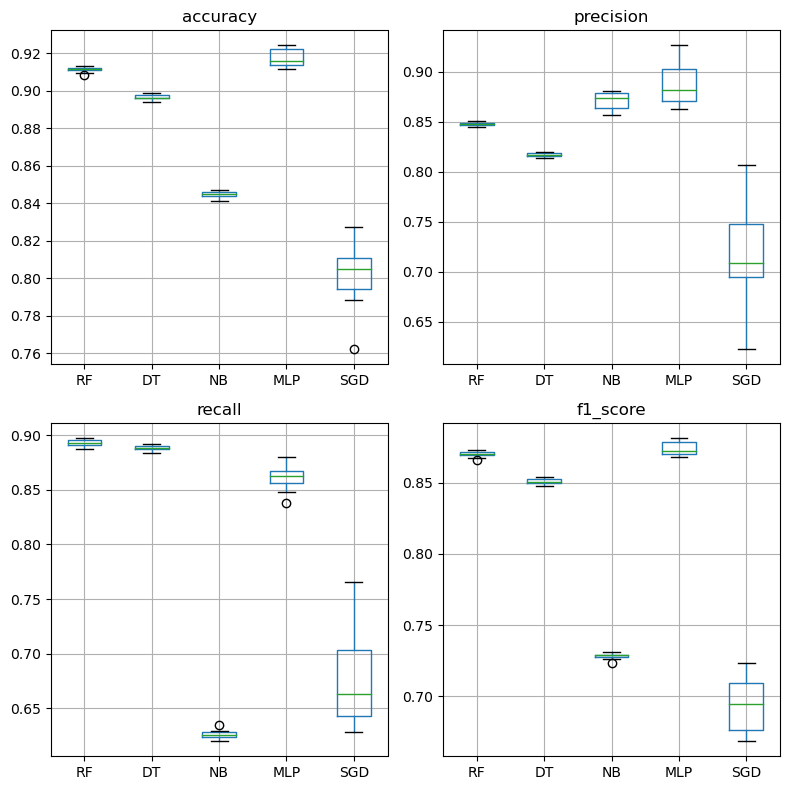

In [44]:
us_metrics = dict()

for n in names:
    us_metrics[n] = pd.DataFrame({l:us_cross[l]['test_' + n] for l in labels})

plot_metrics(us_metrics)

In [45]:
us_wilcoxon_test = perform_wilcoxon_tests(labels, us_metrics, names)

In [46]:
wilcoxon_print(us_wilcoxon_test)

accuracy


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



precision


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(7.0, 0.037109375)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(7.0, 0.037109375)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



recall


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



f1_score


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(6.0, 0.02734375)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(6.0, 0.02734375)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN


## Multi-label classification without undersampling

In [47]:
train_Y_multi = df['type']

In [48]:
SGD_pipe_multi = Pipeline([('norm', StandardScaler()), ('rbf', RBFSampler()), ('clf', SGDClassifier())])
MLP_pipe_multi = Pipeline([('norm', StandardScaler()), ('clf', MLPClassifier())])
NB_clf_multi = GaussianNB()
DT_clf_multi = DecisionTreeClassifier()
RF_clf_multi = RandomForestClassifier()

pipes_multi = [RF_clf_multi, DT_clf_multi, NB_clf_multi, MLP_pipe_multi, SGD_pipe_multi]
cross_multi = dict()

for pipe, l in zip(pipes_multi, labels):
    cross_multi[l] = cross_validate(pipe, train_x, train_Y_multi, scoring={
                                                    'precision': make_scorer(precision_score, labels=['phishing', 'defacement', 'malware'], average='micro'),
                                                    'recall': make_scorer(recall_score, labels=['phishing', 'defacement', 'malware'], average='micro'),
                                                    'f1_score': make_scorer(f1_score, labels=['phishing', 'defacement', 'malware'], average='micro'),
                                                    'accuracy': make_scorer(accuracy_score),
                                                    'phishing_precision': make_scorer(precision_score, labels=['phishing'], average='micro'),
                                                    'phishing_recall': make_scorer(recall_score, labels=['phishing'], average='micro'),
                                                    'phishing_f1_score': make_scorer(f1_score, labels=['phishing'], average='micro'),
                                                    'defacement_precision': make_scorer(precision_score, labels=['defacement'], average='micro'),
                                                    'defacement_recall': make_scorer(recall_score, labels=['defacement'], average='micro'),
                                                    'defacement_f1_score': make_scorer(f1_score, labels=['defacement'], average='micro'),
                                                    'malware_precision': make_scorer(precision_score, labels=['malware'], average='micro'),
                                                    'malware_recall': make_scorer(recall_score, labels=['malware'], average='micro'),
                                                    'malware_f1_score': make_scorer(f1_score, labels=['malware'], average='micro'),
                                                    },
                                return_estimator=True,
                                cv = skf,
                                n_jobs=-1)

In [49]:
names_multi = ['accuracy', 'precision', 'recall', 'f1_score', 'phishing_precision', 'phishing_recall', 'phishing_f1_score', 'defacement_precision', 'defacement_recall', 'defacement_f1_score', 'malware_precision', 'malware_recall', 'malware_f1_score']

def print_metrics_multi(results):
    for name in names_multi:
        print(f'{name:30}', np.round(results["test_"+name].mean(),3), [np.round(elem,3) for elem in results["test_"+name]])

for l in labels:
    print(f'{l}')
    print_metrics_multi(cross_multi[l])
    print()

RF
accuracy                       0.909 [0.909, 0.91, 0.908, 0.908, 0.911, 0.909, 0.908, 0.91, 0.909, 0.909]
precision                      0.856 [0.856, 0.859, 0.854, 0.851, 0.857, 0.856, 0.856, 0.858, 0.855, 0.857]
recall                         0.811 [0.812, 0.808, 0.811, 0.814, 0.814, 0.81, 0.806, 0.812, 0.811, 0.812]
f1_score                       0.833 [0.833, 0.833, 0.832, 0.832, 0.835, 0.832, 0.83, 0.834, 0.832, 0.833]
phishing_precision             0.738 [0.737, 0.746, 0.732, 0.732, 0.742, 0.739, 0.739, 0.737, 0.735, 0.737]
phishing_recall                0.648 [0.651, 0.638, 0.65, 0.653, 0.658, 0.649, 0.637, 0.647, 0.648, 0.649]
phishing_f1_score              0.69 [0.692, 0.688, 0.689, 0.69, 0.697, 0.691, 0.684, 0.689, 0.689, 0.69]
defacement_precision           0.935 [0.936, 0.932, 0.937, 0.935, 0.935, 0.934, 0.931, 0.94, 0.936, 0.937]
defacement_recall              0.956 [0.957, 0.959, 0.957, 0.957, 0.953, 0.955, 0.957, 0.957, 0.956, 0.958]
defacement_f1_score            0.9

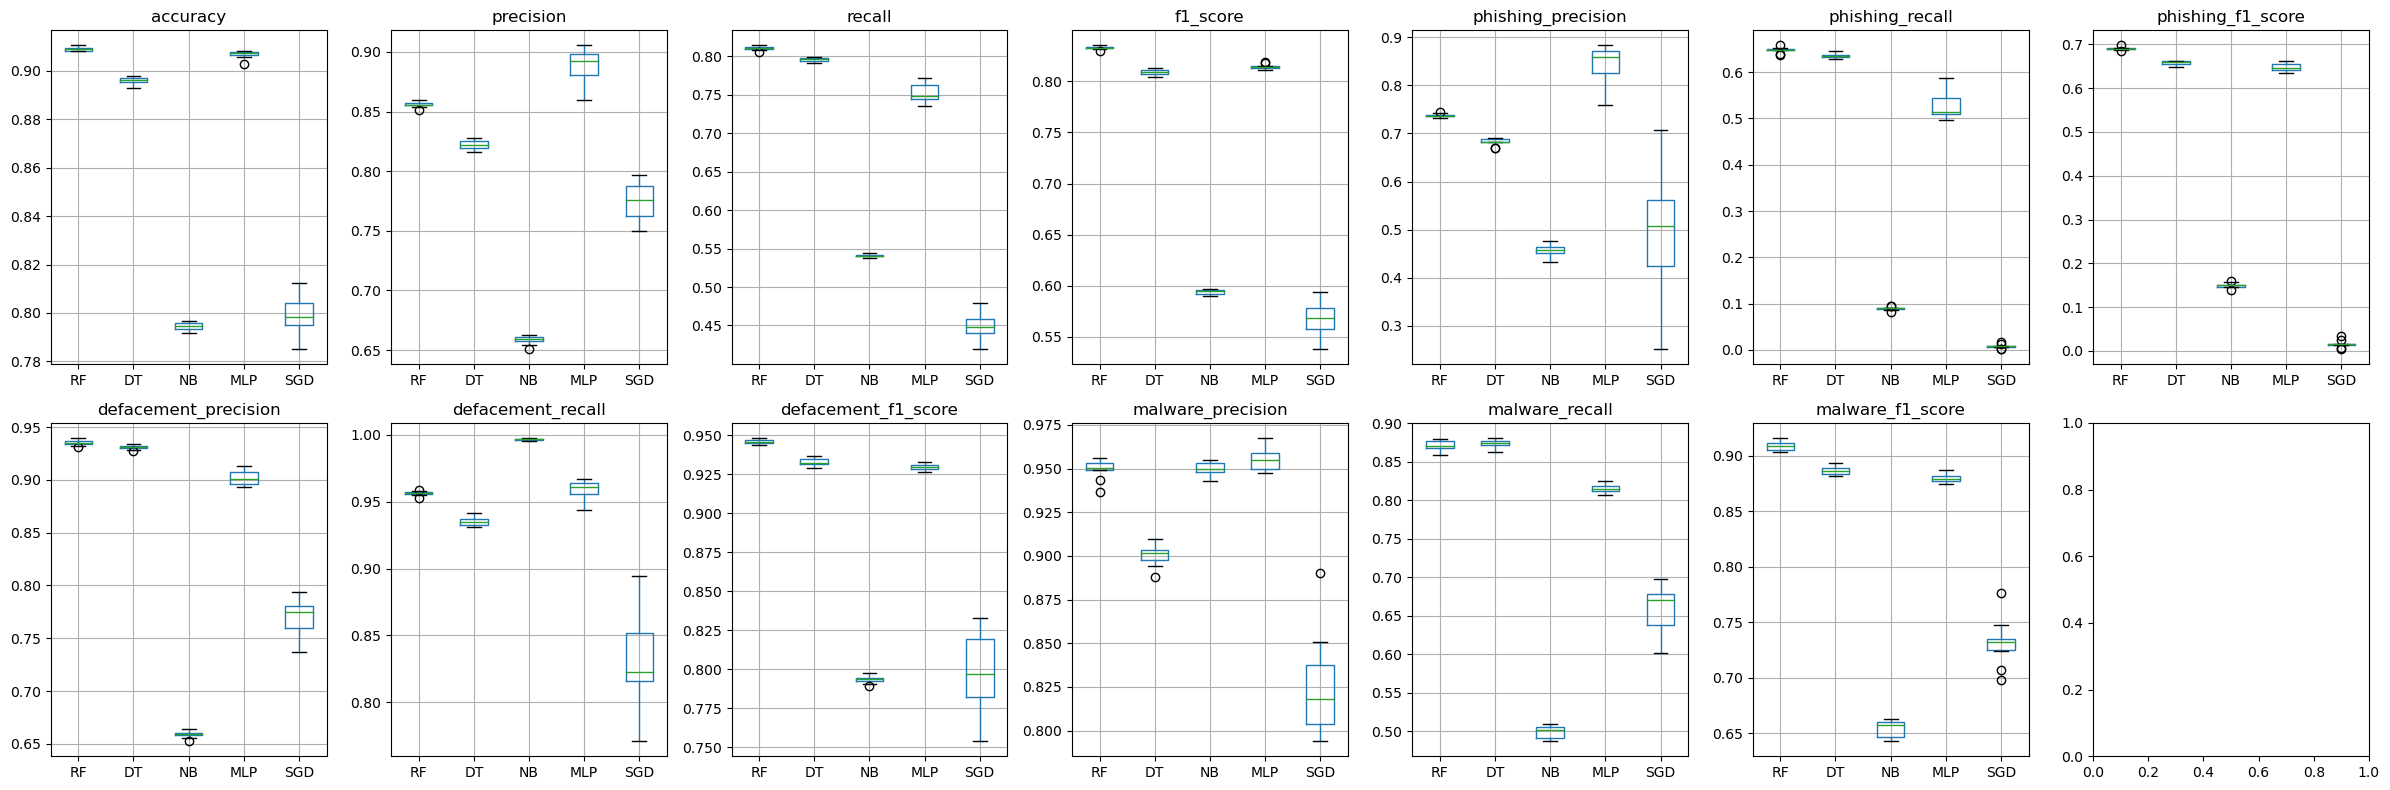

In [50]:
metrics_multi = dict()

for n in names_multi:
    metrics_multi[n] = pd.DataFrame({l:cross_multi[l]['test_' + n] for l in labels})

def plot_metrics_multi(metrics: dict):
    fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(24, 8))
    for i, metric in enumerate(metrics.values()):
        row = i // 7
        col = i % 7
        ax = axes[row, col]
        bars = metric.boxplot(ax=ax, rot=0)
        ax.set_title(names_multi[i])

    plt.tight_layout()
    plt.show()

plot_metrics_multi(metrics_multi)

In [51]:
wilcoxon_test_multi = perform_wilcoxon_tests(labels, metrics_multi, names_multi)

c:\Users\dario\anaconda3\envs\AILab\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\dario\anaconda3\envs\AILab\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [52]:
def wilcoxon_print_multi(wilcoxon_test):
    for name, df in zip(names_multi, wilcoxon_test.values()):
        print(name)
        display(df)
        print()

wilcoxon_print_multi(wilcoxon_test_multi)

accuracy


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(13.0, 0.16015625)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(13.0, 0.16015625)","(0.0, 0.001953125)",NaN



precision


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



recall


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



f1_score


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



phishing_precision


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(1.0, 0.00390625)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(17.0, 0.322265625)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(1.0, 0.00390625)","(17.0, 0.322265625)","(0.0, 0.001953125)",NaN



phishing_recall


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



phishing_f1_score


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(5.0, 0.01953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(5.0, 0.01953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



defacement_precision


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



defacement_recall


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(17.0, 0.322265625)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(17.0, 0.322265625)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



defacement_f1_score


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(2.0, 0.005859375)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(21.0, 0.556640625)"
MLP,"(0.0, 0.001953125)","(2.0, 0.005859375)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(21.0, 0.556640625)","(0.0, 0.001953125)",NaN



malware_precision


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(27.0, 1.0)","(7.0, 0.037109375)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(27.0, 1.0)","(0.0, 0.001953125)",NaN,"(4.0, 0.013671875)","(0.0, 0.001953125)"
MLP,"(7.0, 0.037109375)","(0.0, 0.001953125)","(4.0, 0.013671875)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



malware_recall


,RF,DT,NB,MLP,SGD
RF,NaN,"(1.0, 0.017290280592906253)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(1.0, 0.017290280592906253)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



malware_f1_score


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN


## Multi-label classification with undersampling

In [53]:
us_SGD_pipe_multi = Pipeline([('sample', under_sampler), ('norm', StandardScaler()), ('rbf', RBFSampler()), ('clf', SGDClassifier())])
us_MLP_pipe_multi = Pipeline([('sample', under_sampler), ('norm', StandardScaler()), ('clf', MLPClassifier())])
us_NB_pipe_multi = Pipeline([('sample', under_sampler), ('clf', GaussianNB())])
us_DT_pipe_multi = Pipeline([('sample', under_sampler), ('clf', DecisionTreeClassifier())])
us_RF_pipe_multi = Pipeline([('sample', under_sampler), ('clf', RandomForestClassifier())])

us_pipes_multi = [us_RF_pipe_multi, us_DT_pipe_multi, us_NB_pipe_multi, us_MLP_pipe_multi, us_SGD_pipe_multi]
us_cross_multi = dict()

for pipe, l in zip(pipes_multi, labels):
    us_cross_multi[l] = cross_validate(pipe, train_x, train_Y_multi, scoring={
                                                    'precision': make_scorer(precision_score, labels=['phishing', 'defacement', 'malware'], average='micro'),
                                                    'recall': make_scorer(recall_score, labels=['phishing', 'defacement', 'malware'], average='micro'),
                                                    'f1_score': make_scorer(f1_score, labels=['phishing', 'defacement', 'malware'], average='micro'),
                                                    'accuracy': make_scorer(accuracy_score),
                                                    'phishing_precision': make_scorer(precision_score, labels=['phishing'], average='micro'),
                                                    'phishing_recall': make_scorer(recall_score, labels=['phishing'], average='micro'),
                                                    'phishing_f1_score': make_scorer(f1_score, labels=['phishing'], average='micro'),
                                                    'defacement_precision': make_scorer(precision_score, labels=['defacement'], average='micro'),
                                                    'defacement_recall': make_scorer(recall_score, labels=['defacement'], average='micro'),
                                                    'defacement_f1_score': make_scorer(f1_score, labels=['defacement'], average='micro'),
                                                    'malware_precision': make_scorer(precision_score, labels=['malware'], average='micro'),
                                                    'malware_recall': make_scorer(recall_score, labels=['malware'], average='micro'),
                                                    'malware_f1_score': make_scorer(f1_score, labels=['malware'], average='micro'),
                                                    },
                                return_estimator=True,
                                cv = skf,
                                n_jobs=-1)

In [54]:
for l in labels:
    print(f'{l}')
    print_metrics_multi(us_cross_multi[l])
    print()

RF
accuracy                       0.909 [0.909, 0.91, 0.907, 0.909, 0.911, 0.909, 0.908, 0.91, 0.909, 0.91]
precision                      0.856 [0.856, 0.86, 0.852, 0.852, 0.858, 0.856, 0.856, 0.859, 0.856, 0.857]
recall                         0.811 [0.811, 0.81, 0.809, 0.814, 0.814, 0.81, 0.805, 0.812, 0.811, 0.812]
f1_score                       0.833 [0.833, 0.834, 0.83, 0.833, 0.835, 0.833, 0.83, 0.835, 0.832, 0.834]
phishing_precision             0.739 [0.737, 0.747, 0.729, 0.734, 0.744, 0.741, 0.739, 0.741, 0.736, 0.739]
phishing_recall                0.648 [0.649, 0.642, 0.647, 0.654, 0.656, 0.649, 0.635, 0.648, 0.65, 0.65]
phishing_f1_score              0.69 [0.69, 0.691, 0.686, 0.692, 0.697, 0.692, 0.683, 0.691, 0.691, 0.692]
defacement_precision           0.935 [0.936, 0.933, 0.936, 0.936, 0.935, 0.935, 0.932, 0.938, 0.936, 0.936]
defacement_recall              0.956 [0.956, 0.959, 0.955, 0.957, 0.953, 0.954, 0.958, 0.957, 0.954, 0.957]
defacement_f1_score            0.946 

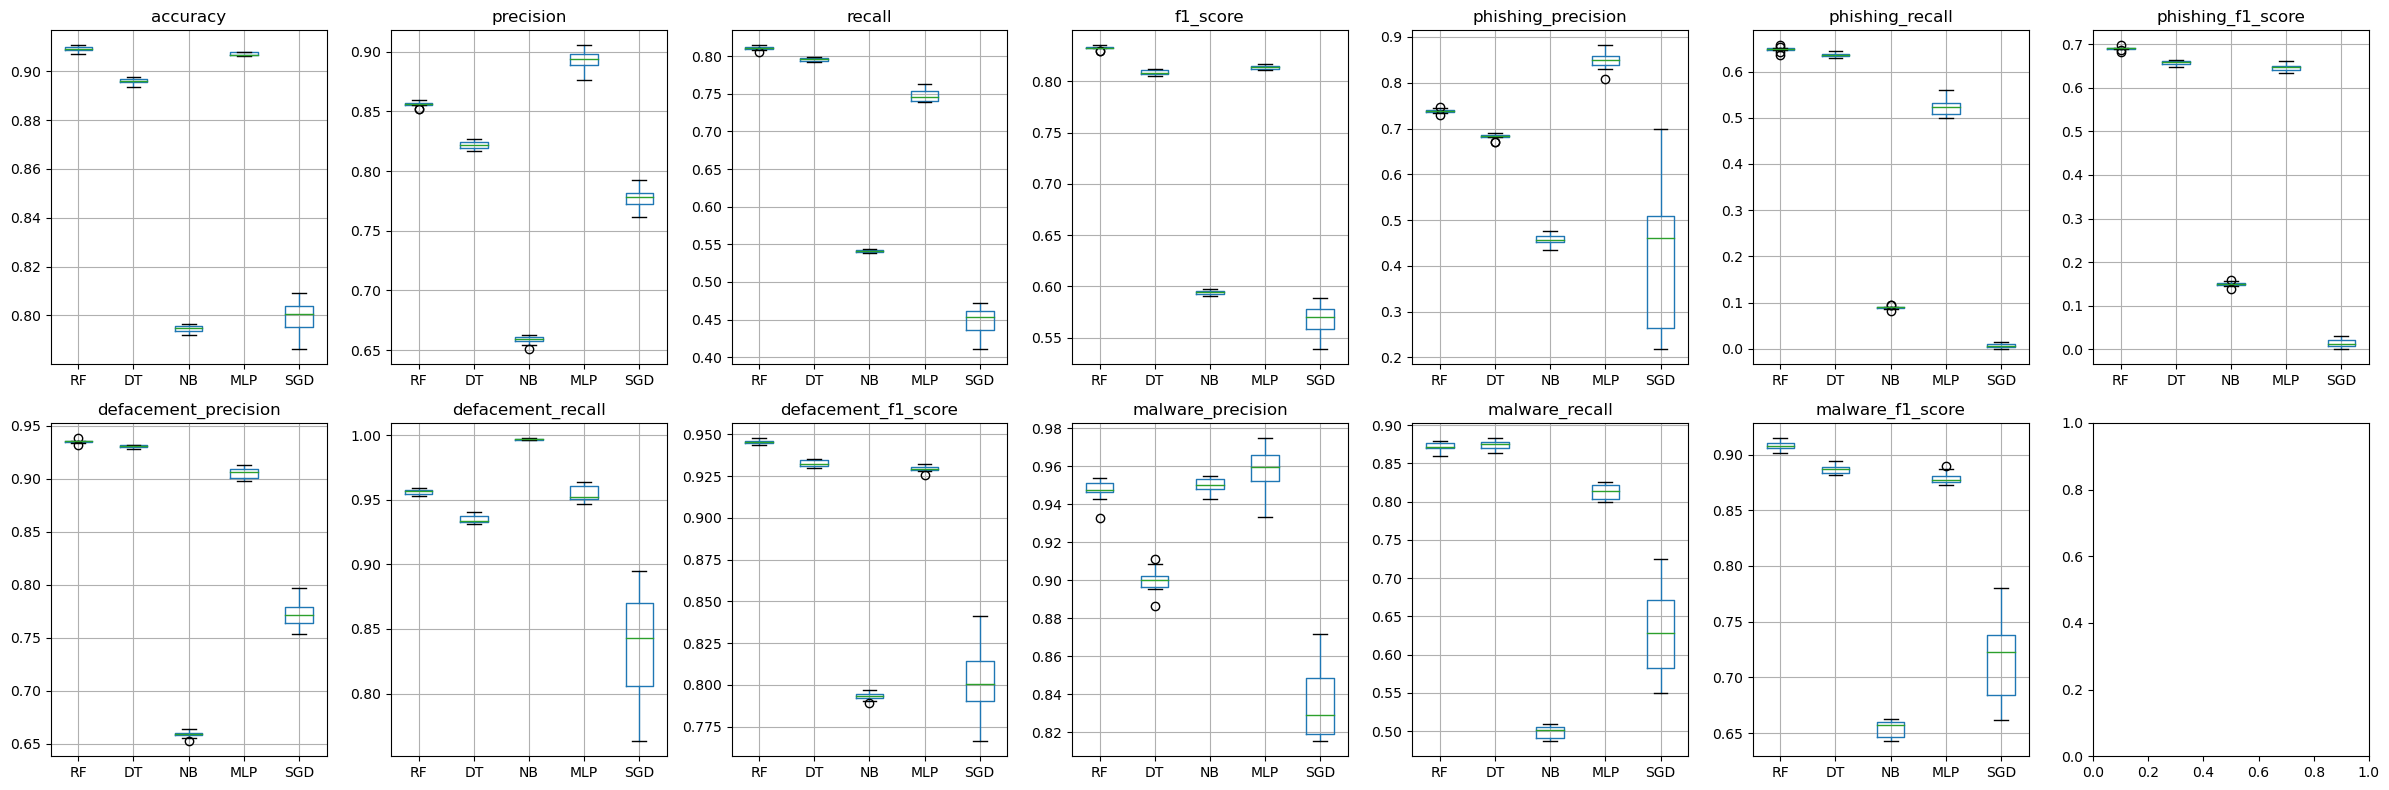

In [55]:
us_metrics_multi = dict()

for n in names_multi:
    us_metrics_multi[n] = pd.DataFrame({l:us_cross_multi[l]['test_' + n] for l in labels})

def plot_metrics_multi(metrics: dict):
    fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(24, 8))
    for i, metric in enumerate(metrics.values()):
        row = i // 7
        col = i % 7
        ax = axes[row, col]
        bars = metric.boxplot(ax=ax, rot=0)
        ax.set_title(names_multi[i])

    plt.tight_layout()
    plt.show()

plot_metrics_multi(us_metrics_multi)

In [56]:
us_wilcoxon_test_multi = perform_wilcoxon_tests(labels, us_metrics_multi, names_multi)

c:\Users\dario\anaconda3\envs\AILab\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\dario\anaconda3\envs\AILab\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [57]:
wilcoxon_print_multi(us_wilcoxon_test_multi)

accuracy


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(10.0, 0.083984375)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(10.0, 0.083984375)","(0.0, 0.001953125)",NaN



precision


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



recall


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



f1_score


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



phishing_precision


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(1.0, 0.00390625)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(25.0, 0.845703125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(1.0, 0.00390625)","(25.0, 0.845703125)","(0.0, 0.001953125)",NaN



phishing_recall


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



phishing_f1_score


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(1.0, 0.00390625)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(1.0, 0.00390625)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



defacement_precision


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



defacement_recall


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(23.0, 0.6953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(23.0, 0.6953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



defacement_f1_score


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(1.0, 0.00390625)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(18.0, 0.375)"
MLP,"(0.0, 0.001953125)","(1.0, 0.00390625)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(18.0, 0.375)","(0.0, 0.001953125)",NaN



malware_precision


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(18.0, 0.375)","(11.0, 0.10546875)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(18.0, 0.375)","(0.0, 0.001953125)",NaN,"(13.0, 0.16015625)","(0.0, 0.001953125)"
MLP,"(11.0, 0.10546875)","(0.0, 0.001953125)","(13.0, 0.16015625)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



malware_recall


,RF,DT,NB,MLP,SGD
RF,NaN,"(1.5, 0.020706216472488822)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(1.5, 0.020706216472488822)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN



malware_f1_score


,RF,DT,NB,MLP,SGD
RF,NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(1.0, 0.00390625)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)","(0.0, 0.001953125)"
MLP,"(0.0, 0.001953125)","(1.0, 0.00390625)","(0.0, 0.001953125)",NaN,"(0.0, 0.001953125)"
SGD,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)",NaN


## Conclusions

In [64]:
# Do wilcoxon test between undersampling and no sampling

def perform_sampling_wilcoxon_tests(classifier_names: list, metrics_no_sample: dict, metrics_with_sample: dict, metric_names: list) -> pd.DataFrame:
    wilcoxon_tests = pd.DataFrame(index=classifier_names, columns=metric_names)
    for i, classifier in enumerate(classifier_names):
        for j, metric_name in enumerate(metric_names):
            wilcoxon_tests.iloc[i, j] = wilcoxon(metrics_no_sample[metric_name][classifier], metrics_with_sample[metric_name][classifier])
    return wilcoxon_tests

sampling_wilcoxon_test = perform_sampling_wilcoxon_tests(labels, default_metrics, us_metrics, names)
sampling_wilcoxon_test

,accuracy,precision,recall,f1_score
RF,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
DT,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
NB,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(12.0, 0.130859375)"
MLP,"(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(0.0, 0.001953125)"
SGD,"(5.0, 0.01953125)","(0.0, 0.001953125)","(0.0, 0.001953125)","(16.0, 0.275390625)"


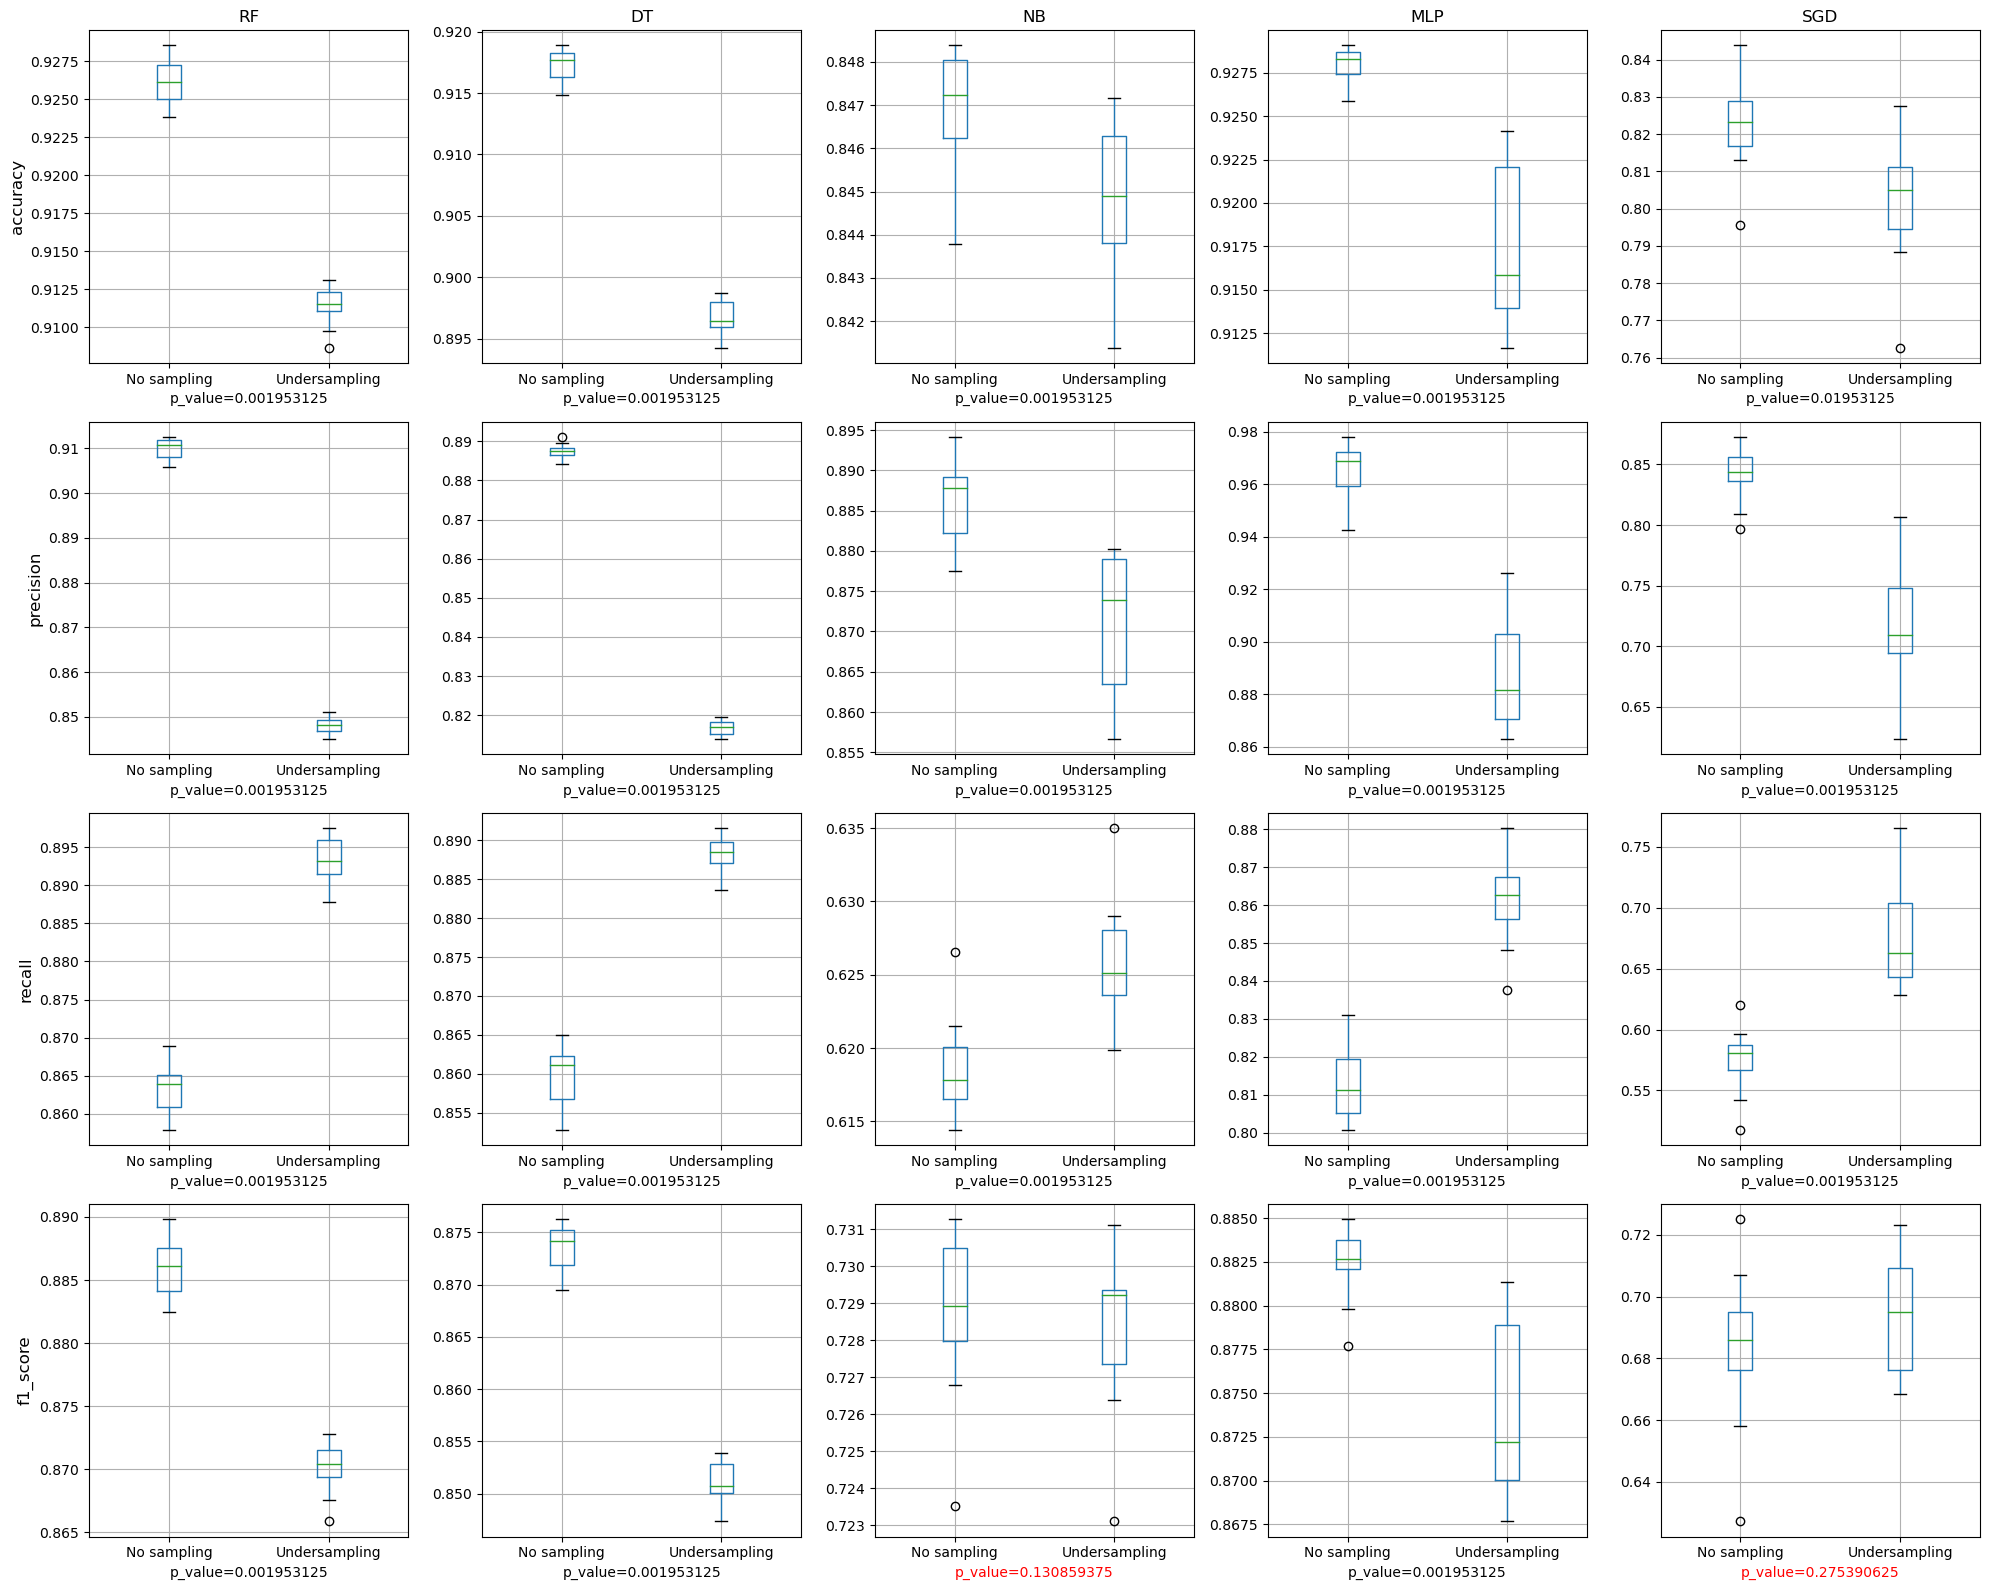

In [79]:
# Evaluate undersampling performance

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))
for i, n in enumerate(names):
    for j, l in enumerate(labels):
        ax = axes[i, j]
        temp_df = pd.DataFrame({'No sampling':cross[l]['test_'+n], 'Undersampling':us_cross[l]['test_'+n]})
        bars = temp_df.boxplot(ax=ax, rot=0)
        p_value = sampling_wilcoxon_test.iloc[j, i].pvalue
        color = 'black' if p_value < P_VALUE_MAX else 'red' 
        ax.set_xlabel(f'p_value={p_value}', color=color)
        if i == 0: ax.set_title(l)
        if j == 0: ax.set_ylabel(n, size='large')
    
plt.tight_layout()
plt.show()

In [ ]:
# Do wilcoxon test for multiclass between sampling and no sampling


In [ ]:
# Evaluate undersampling for multiclass

fig, axes = plt.subplots(nrows=len(names_multi), ncols=5, figsize=(5*len(names_multi), 16))
for i, n in enumerate(names_multi):
    for j, l in enumerate(labels):
        ax = axes[i, j]
        temp_df = pd.DataFrame({'No sampling':cross[l]['test_'+n], 'Undersampling':us_cross[l]['test_'+n]})
        bars = temp_df.boxplot(ax=ax, rot=0)
        if i == 0: ax.set_title(l)
        if j == 0: ax.set_ylabel(n,  size='large')
    
plt.tight_layout()
plt.show()

In [ ]:
# compare overall performance between binary and multiclass

## TODO

- compare results

### Didn't do

- Detect base 64/hex (too hard)
- Detect homographs (didn't find any in the dataset)
- Detect "spoofed" hostnames in other parts of the URL (hard to match, found only one)
- Match specific words (admin, login, password...) OR do stemming